In [1]:
%%capture
%cd '/Users/nagarajuoruganti/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration'

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('icefire')

## Load data

In [3]:
records = [path.split('/') for path in glob(f'*/*/*') if 'resized_images' not in path]
df = pd.DataFrame(records, columns = ['kind', 'disease', 'filename'])
print(f'Total images in the dataset: {len(df)}')
df.head()

Total images in the dataset: 2357


,kind,disease,filename
0,Test,melanoma,ISIC_0000031.jpg
1,Test,melanoma,ISIC_0000030.jpg
2,Test,melanoma,ISIC_0000026.jpg
3,Test,melanoma,ISIC_0000022.jpg
4,Test,melanoma,ISIC_0000036.jpg


# Data distributions

### How many images in train and test dataset?

In [4]:
counts = dict(df['kind'].value_counts())
pct_counts = dict(df['kind'].value_counts() / len(df) * 100)

dist_df = pd.concat([pd.DataFrame.from_dict(counts, orient = 'index'),
                     pd.DataFrame.from_dict(pct_counts, orient = 'index')], axis = 1)
dist_df.columns = ['images', '% count']
print(tabulate(dist_df, headers='keys', tablefmt='psql'))

+-------+----------+-----------+
|       |   images |   % count |
|-------+----------+-----------|
| Train |     2239 |  94.9936  |
| Test  |      118 |   5.00636 |
+-------+----------+-----------+


Among the 2357 images in the project dataset, 95% of them are allocated for train and the remaining for test.

### How are the images distributed by disease?

In [5]:
count_df = df.groupby(by = ['kind', 'disease'])['filename'].count().reset_index()
count_df.rename(columns = {'filename': 'count'}, inplace = True)
count_df['% count'] = 0
for kind in ['Train', 'Test']:
    cond = count_df['kind'] == kind
    count_df.loc[cond, '% count']  = (count_df.loc[cond, 'count'] / dist_df.loc[dist_df.index == kind]['images'].values[0] * 100).round(2)
count_df.sort_values(by = ['kind', 'count'], ascending = True, inplace = True)

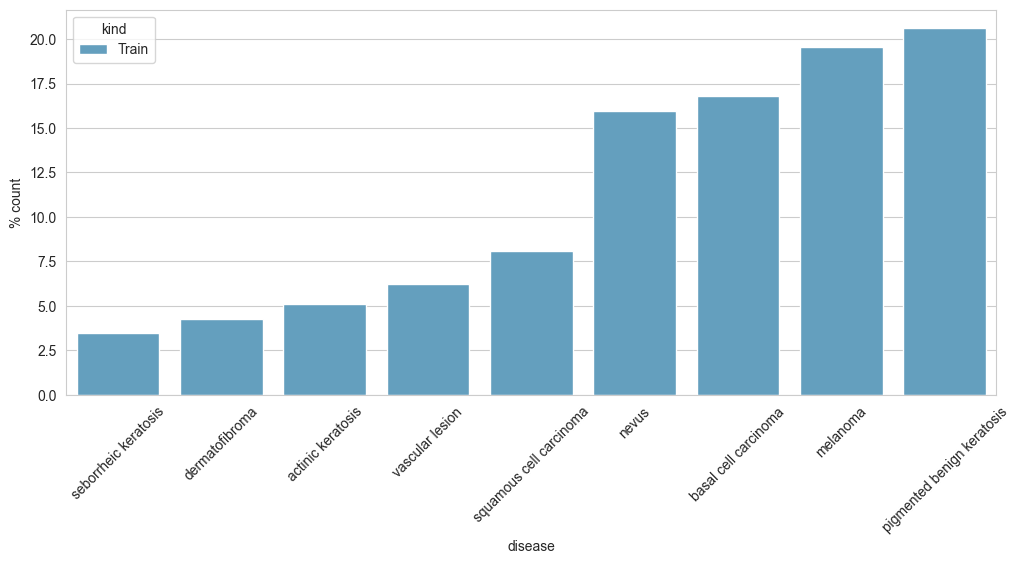

In [7]:
plt.figure(figsize = (12, 5))
sns.barplot(data = count_df, x = 'disease', y = '% count', hue = 'kind')
plt.xticks(rotation = 45)
plt.show()

The distribution of images among disease types is not consistent between the training and test datasets. For example, in the case of actinic keratosis, it constitutes 13.5% of the total test samples, but only 5% in the training samples. This discrepancy indicates that the weighting applied to address the imbalanced dataset during training is not effectively translated to the test dataset.

### View a sample image by disease

In [7]:
from PIL import Image

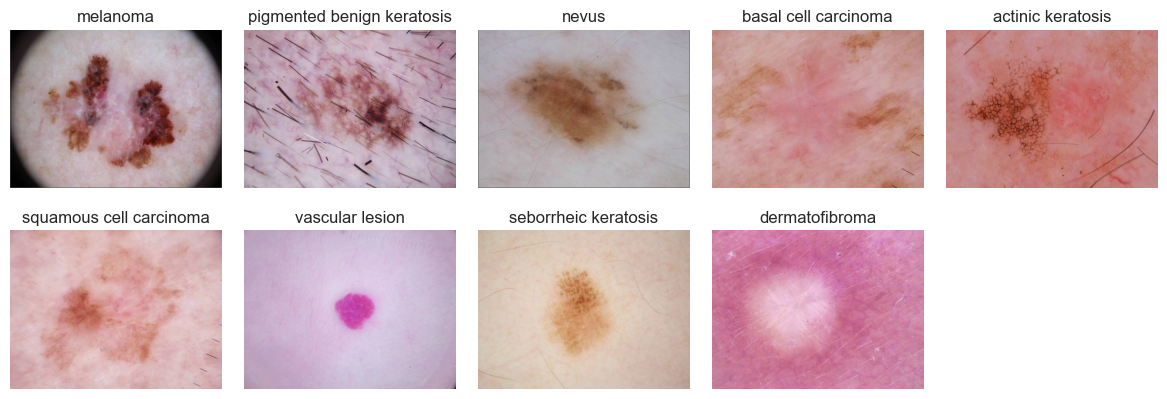

In [8]:
diseases = df['disease'].unique().tolist()
fig, axes = plt.subplots(2, 5, figsize = (12, 4))
for idx, ax in enumerate(axes.flatten()):
    if idx < len(diseases):
        item = df[df['disease'] == diseases[idx]].head(1).values[0]
        img = Image.open('/'.join(item))
        ax.imshow(img)
        ax.set_title(diseases[idx])
        ax.grid(visible=False)
        ax.axis('off')
    else:
        ax.remove()
plt.tight_layout(h_pad = 3, w_pad = 0)
plt.show()

### Inspect dimensions of all the images

In [9]:
for idx, row in df.iterrows():
    im = Image.open('/'.join(row))
    df.loc[idx, 'width'] = im.width
    df.loc[idx, 'height'] = im.height

In [ ]:
# distribution
fig, axes = plt.subplots(1, 2, figsize = (8, 3), sharex=True)
sns.histplot(data = df, x = 'height', hue = 'kind', ax = axes[0])
axes[0].set_title('Height')
sns.histplot(data = df, x = 'width', hue = 'kind', ax = axes[1])
axes[1].set_title('width')
plt.tight_layout()
plt.show()

In [ ]:
df.describe().round(0)

There is resonable variability in the image size (height, width). The project recommends to compress the images to 180 x 180 pixels.

# Compress images and save in the data directory

We are resizing the images in the preprocessing step and move them to the data folder to save space on Google Drive.

In [ ]:
def resize_images(dest_dir, img_size = (180, 180)):
    from tqdm import tqdm
    files = [f for f in glob('*/*/*') if ('.jpg' in f) & (dest_dir not in f)]
    que = tqdm(files, total = len(files))
    for file in que:
        os.makedirs(f"{dest_dir}/{'/'.join(file.split('/')[:-1])}", exist_ok = True)
        Image.open(file).resize(img_size).save(f'{dest_dir}/{file}')        # open image -> resize -> save in the destination directory

In [ ]:
# target size
target_image_size = (180, 180)

# Train images
resize_images(dest_dir = 'resized_images', img_size = target_image_size)